On rajoute les données meteo

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn import linear_model

In [23]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [24]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [25]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [26]:
%run Regression_GAM_Gamma.py

# Val croisée

In [27]:
n_knots = 10
lasso_grid = [1, 3, 10, 30, 100, 300, 1000]
max_lag = 7

In [7]:
for curr_alpha in lasso_grid:
    for curr_lag in tqdm(range(max_lag+1)):
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
        for curr_split in range(9):
        
            # Entraintement
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]
            #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                                   curr_train_X_standard, 
                                                                                   liste_stations_debit)
            curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                          curr_train_X_standard[colonnes_meteo_stations]],
                                                         axis = 1)
            # Ajout AR
            colonnes_reg = colonnes_meteo_stations
            for i in range(curr_lag+1):
                variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
            #LASSO
            curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
            model = linear_model.Lasso(alpha = curr_alpha/1000, max_iter = 30000)
            model.fit(X = curr_train_X_standard_residus[colonnes_reg],
                  y = curr_train_X_standard_residus[liste_stations_debit])
        
            # Predictions Standard
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]
            curr_test_X_standard =fct_Standardize(curr_test_X, 
                                                  curr_train_X_mean, curr_train_X_std, 
                                                  liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
            curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                      curr_test_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
            # Ajout variables AR
            for i in range(curr_lag+1):
                variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)

            # LASS0
            curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
            predictions_test_Y_standard_residus = model.predict(curr_test_X_standard_residus[colonnes_reg])
            predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
            predictions_test_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values
            # Filtre sur les dates
            resultat = pd.DataFrame()
            for curr_date in liste_dates:
                resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
            resultat = resultat.sort_values(by = "Date")
            predictions_test_Y_standard_residus = resultat.copy()
            # On rajoute la compo saisonnalité
            predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
            predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
            for code in liste_stations_debit:
                predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

            # Score standard
            curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]
            curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

            # Score
            predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, curr_train_X_mean,
                                                  curr_train_X_std, liste_stations_debit)
            predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
            curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []

        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/GAMLASSOAR/CV_RMSE_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/GAMLASSOAR/CV_MAE_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/GAMLASSOAR/CV_R2_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/GAMLASSOAR/CV_RMSE_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/GAMLASSOAR/CV_MAE_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/GAMLASSOAR/CV_R2_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv",
                              index=False)

100%|█████████████████████████████████████████████| 8/8 [04:15<00:00, 31.91s/it]


## Selection

In [8]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


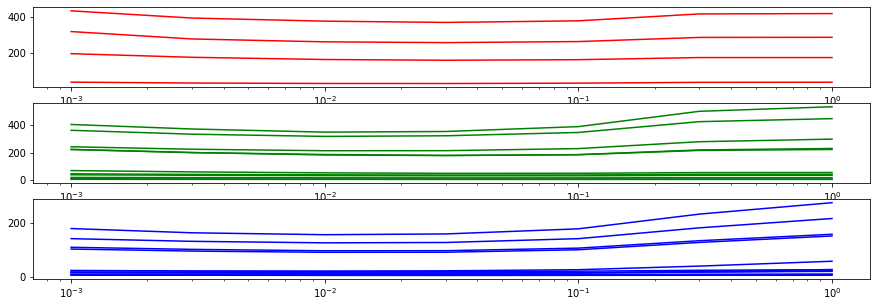

In [12]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMLASSOAR/CV_RMSE_" + str(curr_alpha)+"_" + str(curr_lag) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Standard

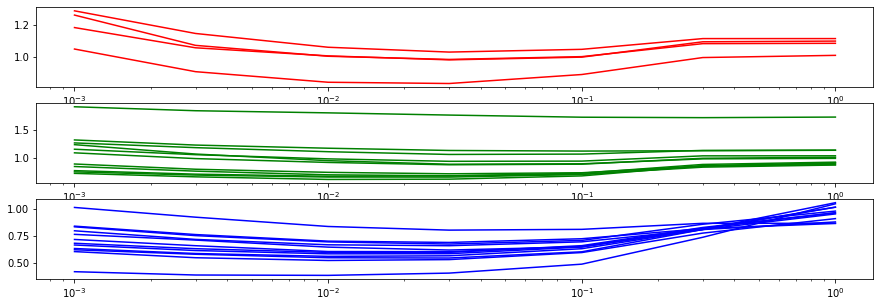

In [14]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMLASSOAR/CV_RMSE_standard_" + str(curr_alpha) +"_" + str(curr_lag)+ ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Moyen

In [15]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMLASSOAR/CV_RMSE_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Alpha"] = curr_alpha/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

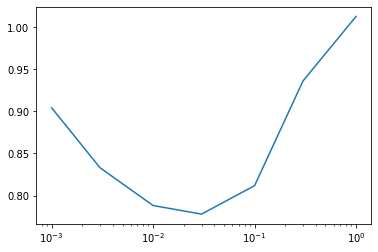

In [16]:
plt.plot(cv_moyen.groupby("Alpha").mean().index, cv_moyen.groupby("Alpha").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

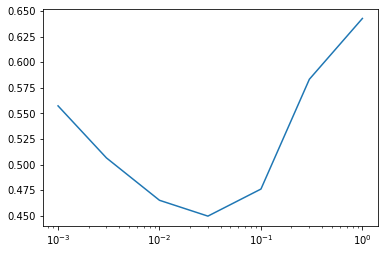

In [17]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMLASSOAR/CV_MAE_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Alpha"] = curr_alpha/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])
        
plt.plot(cv_moyen.groupby("Alpha").mean().index, cv_moyen.groupby("Alpha").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

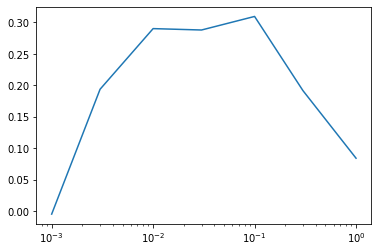

In [18]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMLASSOAR/CV_R2_standard_" + str(curr_alpha) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Alpha"] = curr_alpha/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])
        
plt.plot(cv_moyen.groupby("Alpha").mean().index, cv_moyen.groupby("Alpha").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

In [15]:
pd.read_csv("../Data/GAMLASSOAR/CV_RMSE_standard_30_1.csv")["Moyenne"].mean()

0.7815430930907531

In [17]:
pd.read_csv("../Data/GAMLASSOAR/CV_MAE_standard_30_1.csv")["Moyenne"].mean()

0.4456951024398368

In [19]:
pd.read_csv("../Data/GAMLASSOAR/CV_R2_standard_30_1.csv")["Moyenne"].mean()

0.6798972080509196

# Test

In [28]:
alpha = 0.03

In [29]:
# Entraintement
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]
model = linear_model.Lasso(alpha = alpha, max_iter = 20000)
model.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
          y = mesures_train_X_standard[liste_stations_debit])

Lasso(alpha=0.03, max_iter=20000)

Text(0.5, 0, 'LASSO AR Feature Importance')

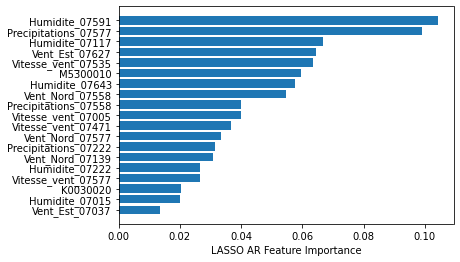

In [30]:
coeff = model.coef_
station1=coeff[0,:]
sorted_idx = station1.argsort()
plt.barh(mesures_train_X.columns[sorted_idx][-20:-1], station1[sorted_idx][-20:-1])
plt.xlabel("LASSO AR Feature Importance")


In [31]:
# Predictions Standard
liste_dates = mesures_test_Y["Date"]
mesures_test_X_standard =fct_Standardize(mesures_test_X, 
                                         mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
predictions_test_Y_standard = model.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values

In [32]:
# Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [33]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

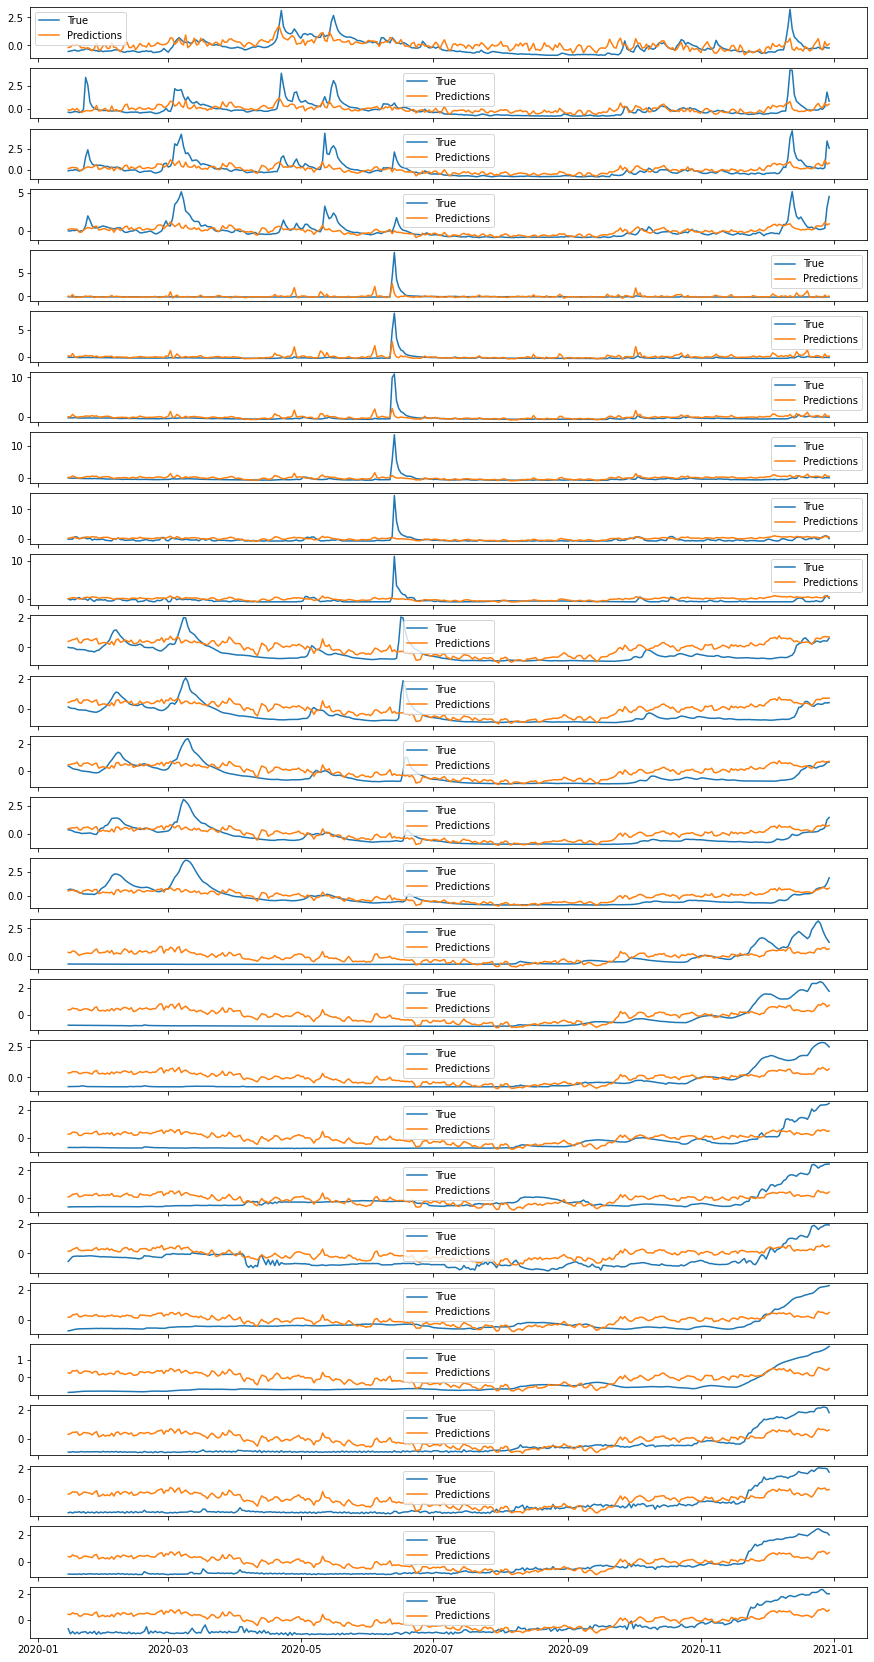

In [34]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [35]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.561652,0.442124,0.320420
1,O2620010,0.684383,0.452108,0.168494
2,O6140010,0.756808,0.490129,0.195144
3,O9000010,0.810101,0.488398,0.198889
4,K0030020,0.600009,0.193156,0.252805
5,K0100020,0.612673,0.297223,0.316992
6,K0260020,0.867541,0.393942,0.183268
7,K0550010,0.981667,0.518716,0.181099
8,K0690010,1.072558,0.593788,0.157661
9,K0910050,0.913519,0.585676,0.175967


In [36]:
test_scores_standard.to_csv("../Data/GAMLASSOAR/Test_scores_standard.csv",
                   index = False)

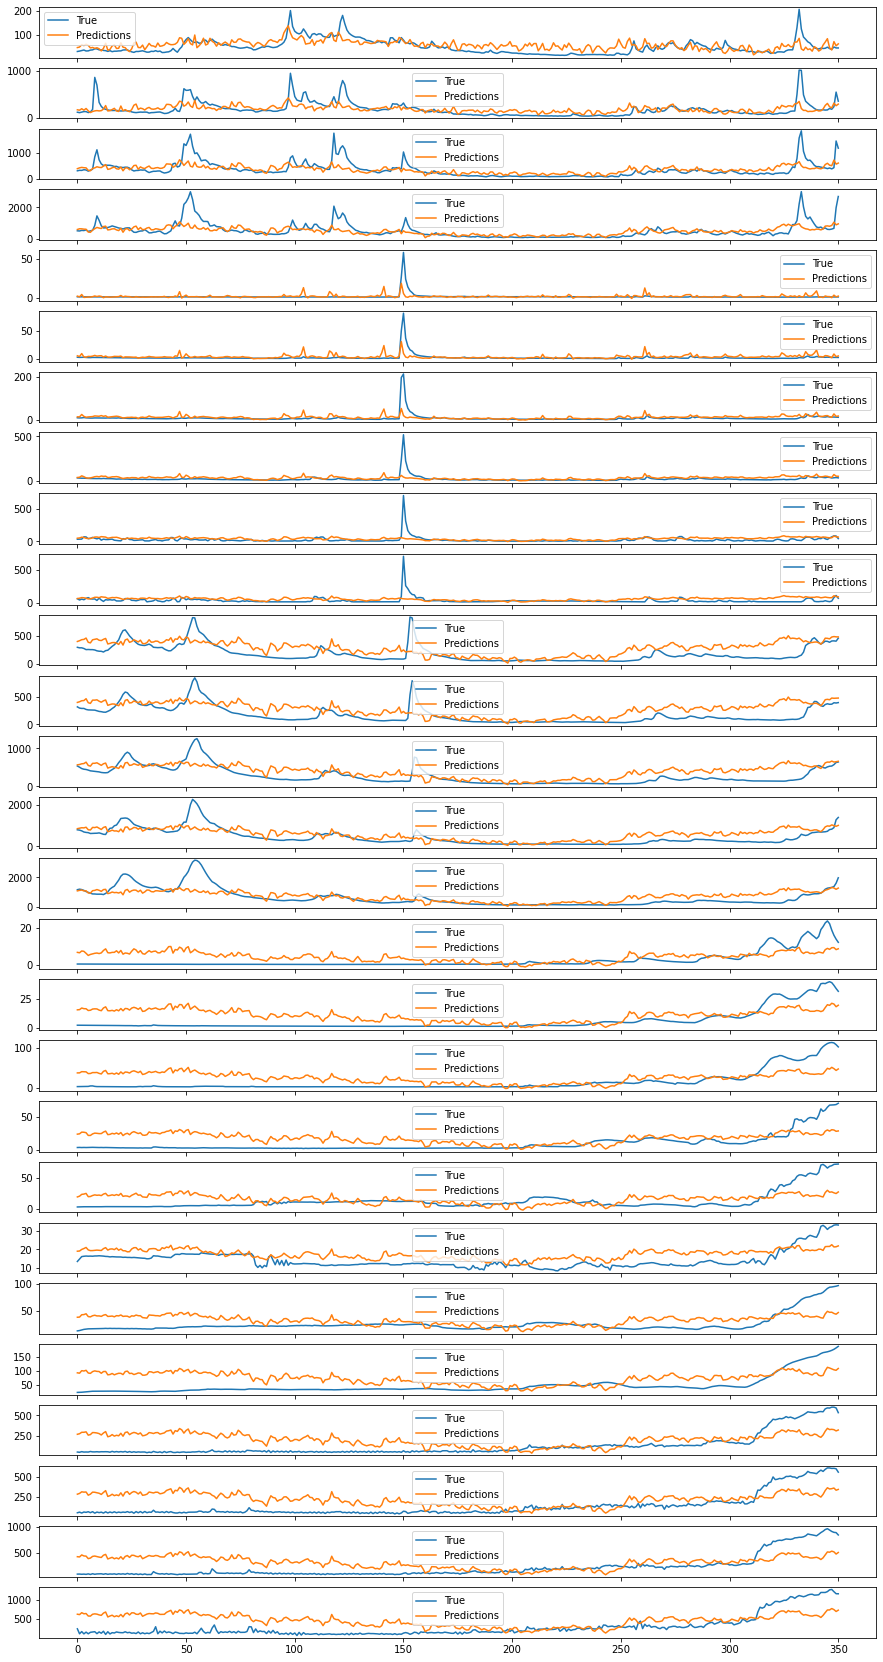

In [37]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [38]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,26.072789,20.524107,0.320420
1,O2620010,135.654368,89.614257,0.168494
2,O6140010,249.020860,161.272425,0.195144
3,O9000010,393.883134,237.466618,0.198889
4,K0030020,3.679601,1.184546,0.252805
5,K0100020,5.768827,2.798604,0.316992
6,K0260020,16.070747,7.297572,0.183268
7,K0550010,35.764526,18.898091,0.181099
8,K0690010,47.982574,26.564021,0.157661
9,K0910050,52.748901,33.818427,0.175967


In [39]:
test_scores.to_csv("../Data/GAMLASSOAR/Test_scores.csv",
                   index = False)

In [40]:
np.sum(model.coef_ == 0, axis = 1)

array([207, 211, 213, 218, 227, 217, 221, 217, 219, 224, 226, 225, 226,
       228, 228, 229, 232, 233, 225, 228, 227, 229, 230, 227, 229, 226,
       225])